In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import geopandas
from geopandas import GeoDataFrame
import os
from fiona.crs import from_epsg
import matplotlib as mpl
import statsmodels.api as sm
import shapely
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pysal as ps
import seaborn as sns
from matplotlib import colors
import shapefile as shp
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from sklearn import preprocessing
%matplotlib inline

### Download the Mental Health Service Finder Data 

In [2]:
path= os.getenv("PUIDATA") + '/Mental_Health_Service_Finder_Data.csv'
data_finder = GeoDataFrame.from_csv(path)
data_finder.reset_index(level= 0).head(2)

,name_1,name_2,street_1,street_2,city,zip,phone,website,latitude,longitude,...,flag_hv,flag_dv,flag_chld,flag_yad,flag_adlt,flag_snr,flag_si,filter_military,filter_inpatient_svc,filter_residential_pgm
0,Allied Service Center NYC,Queens Opioid Treatment Clinic Otp 3,2036 Amsterdam Avenue,NaN,NEW YORK,10032,212-645-0875,NaN,40.835269,-73.940293,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Beth Israel Medical Center,Ny Center Addiction Treatment Op 1,25 12th Street,NaN,BROOKLYN,11215,718-965-7900,NaN,40.671835,-73.997069,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Create mental health serivce geometry from corrdinates and visualize them as points

data = data_finder.reset_index(level= 0).copy()
data['geometry'] = data.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
data = geopandas.GeoDataFrame(data, geometry='geometry')
data.to_file('NY_shapefile/NY_shapefile/NY.shp', driver='ESRI Shapefile')

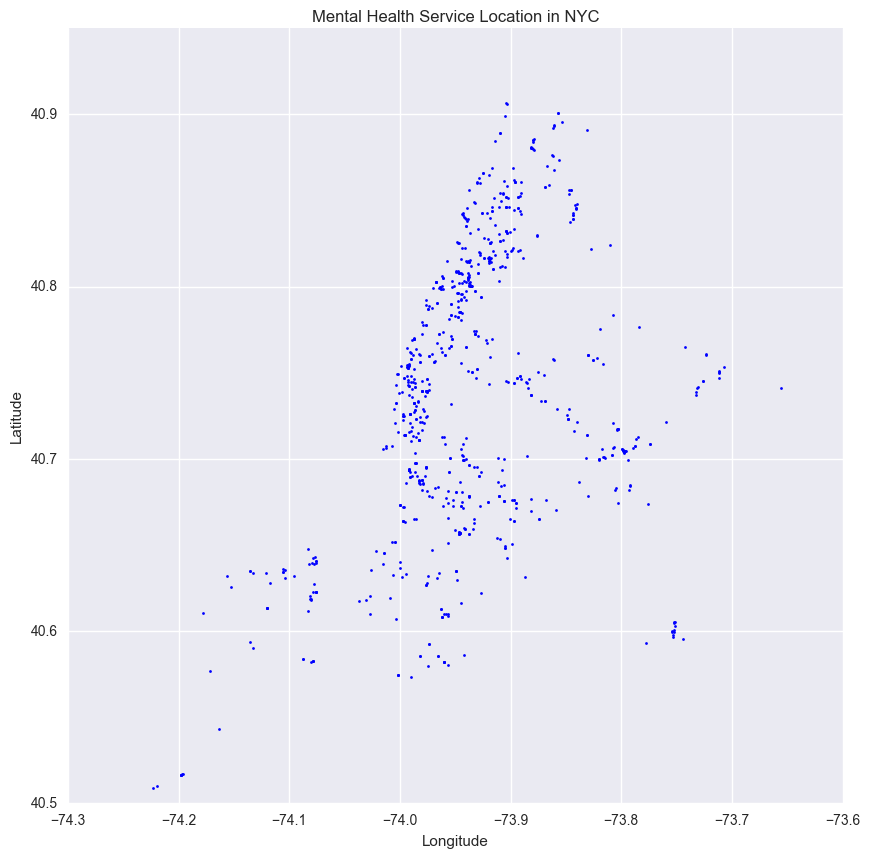

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
data.plot(column='zip',color='blue',alpha=1,linewidth=0.1,ax=ax)
plt.title("Mental Health Service Location in NYC")

### Download NYC Census Tract Shape File

In [5]:
# load NYC shape file for better visualization

shape_path= os.getenv("PUIDATA")+"/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...


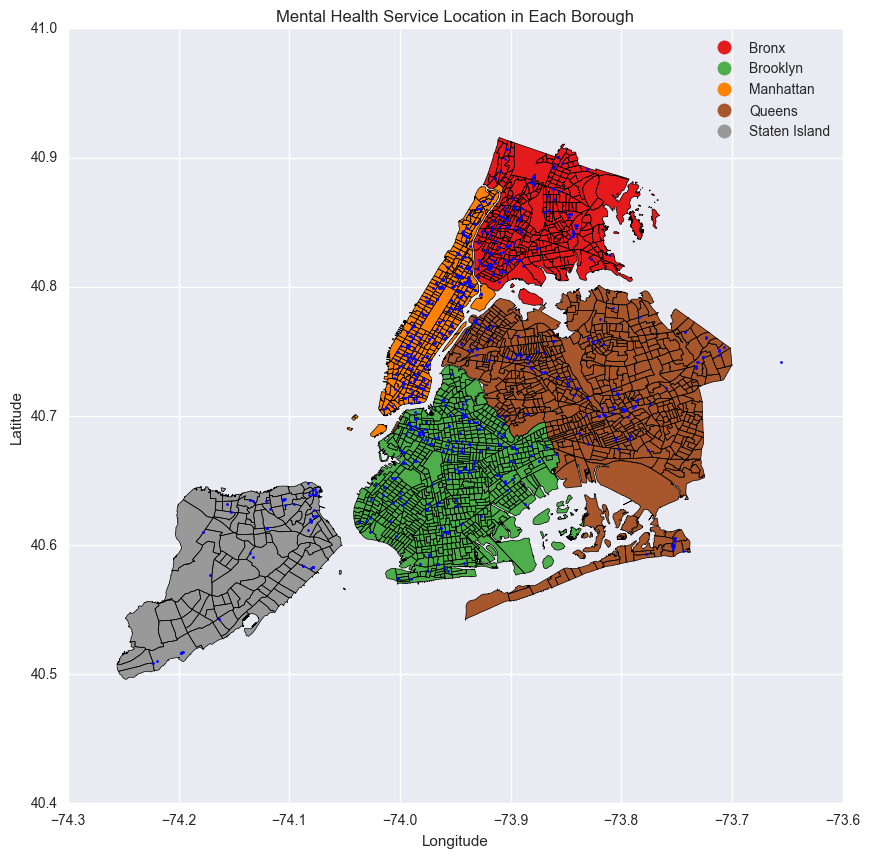

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ct_shape.plot(column='BoroName', alpha=1, linewidth=0.5, ax=ax, legend=True)
data.plot(column='zip', color = 'blue', alpha=1, linewidth=0.1, ax=ax) #colormap='winter'
plt.title("Mental Health Service Location in Each Borough")

### Download Population Census Tract Data

In [7]:
ct_data=DataFrame.from_csv('ACS_CT2010.csv')
ct_shape_pop=ct_shape.join(ct_data['SE_T002_002']) 

In [8]:
ct_shape_pop.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,SE_T002_002
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...,23590.33
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...,16629.33


/Users/YueCai/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


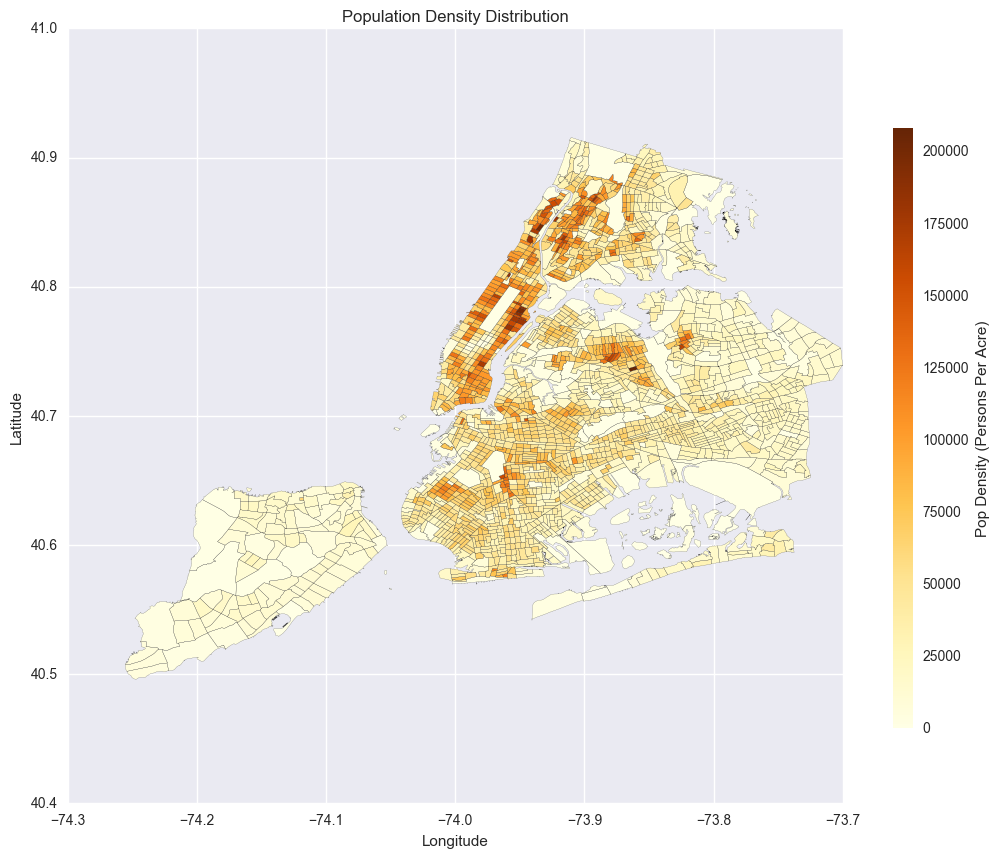

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ct_shape_pop.plot(column='SE_T002_002',colormap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Population Density Distribution")
norm = mpl.colors.Normalize(vmin=ct_shape_pop['SE_T002_002'].min(),
                              vmax=ct_shape_pop['SE_T002_002'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='YlOrBr', norm=norm, spacing='proportional')
cb.set_label('Pop Density (Persons Per Acre)')

## I planned to create a geospacial analysis on the finder spot, it turns out that does not work for some reason...

In [10]:
# sort and gruop the city names into borough based on zip infro

data1 =data.reset_index(level= 0)[['name_1','city','zip','longitude','latitude','geometry']]
data1.head(2)

,name_1,city,zip,longitude,latitude,geometry
0,Allied Service Center NYC,NEW YORK,10032,-73.940293,40.835269,POINT (-73.94029304839991 40.835269103)
1,Beth Israel Medical Center,BROOKLYN,11215,-73.997069,40.671835,POINT (-73.99706919269991 40.6718349352999)


In [11]:
data1.isnull().sum()

name_1       0
city         0
zip          0
longitude    2
latitude     0
geometry     0
dtype: int64

In [12]:
data_finder = data1[data1['longitude'].notnull()]

In [13]:
#b=[]
#for i in range(len(data_finder)):
    #b.append(ct_shape[ct_shape.geometry.intersects
                      #(data_finder.iloc[i].geometry)].BoroCT2010.ix)
    
#data_finder['BoroCT2010']=b

In [14]:
#data_finder

In [15]:
#finder =pd.DataFrame(data_finder.values.groupby('BoroCT2010').size()).reset_index(level = 0)
#finder.columns =['BoroCT2010_T','Finder Number']
#finder.head()

In [16]:
data1.city.unique()

array(['NEW YORK', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND',
       'New York', 'Bronx', 'Brooklyn', 'Staten Island', 'Woodside',
       'Astoria', 'Ridgewood', 'Jackson Heights', 'Forest Hills',
       'Little Neck', 'Far Rockaway', 'Jamaica', 'Queens Village',
       'New Hyde Park', 'Elmhurst', 'Hollis', 'Sunnyside', 'Glen Oaks',
       'Corona', 'Flushing', 'Kew Gardens', 'Bellerose', 'Richmond Hill',
       'South Ozone Park', 'Long Island City', 'Fresh Meadows',
       'Rego Park', 'East Elmhurst'], dtype=object)

In [17]:
# https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

data1['city'].replace({'New York': 'MANHATTAN', 'Bronx': 'BRONX', 'Staten Island': 'STATEN ISLAND',
                      'Brooklyn': 'BROOKLYN','Woodside':'QUEENS', 'Astoria':'QUEENS',
                      'Jackson Heights':'QUEENS', 'Forest Hills': 'QUEENS', 'Little Neck':'QUEENS', 
                      'Far Rockaway':'QUEENS', 'Jamaica':'QUEENS', 'Queens Village': 'QUEENS',
                      'New Hyde Park': 'QUEENS', 'Elmhurst': 'QUEENS', 'Hollis': 'QUEENS', 
                      'Sunnyside': 'QUEENS', 'Glen Oaks': 'QUEENS', 'Corona': 'QUEENS',
                      'Flushing': 'QUEENS', 'Kew Gardens': 'QUEENS', 'Bellerose':'QUEENS', 
                      'Richmond Hill': 'QUEENS', 'South Ozone Park': 'QUEENS', 'Ridgewood': 'QUEENS',
                      'Long Island City': 'QUEENS', 'Fresh Meadows': 'QUEENS','Rego Park': 'QUEENS', 
                      'East Elmhurst': 'QUEENS','NEW YORK':'MANHATTAN'}, inplace = True)
data1 = data1.rename(index=str, columns={'city':'Borough'})

In [18]:
data2 = data1.groupby('Borough').count()['name_1']
data2 = pd.DataFrame(data2.sort_values(ascending=0))
data2= data2.reset_index(level= 0)
data2.columns = ['Borough','Mental Health Service Center Number']
data2.head()

,Borough,Mental Health Service Center Number
0,MANHATTAN,284
1,BROOKLYN,212
2,QUEENS,142
3,BRONX,141
4,STATEN ISLAND,57


### Download 311 complaint data

In [19]:
!curl -O "https://data.cityofnewyork.us/resource/erm2-nwe9.csv"
os.system("mv erm2-nwe9.csv" + os.getenv("PUIDATA"))
data_311 = pd.read_csv("erm2-nwe9.csv")
data_311.head(2)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:02:28 --:--:--     0^C


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,34994325,12/13/2016 02:14:20 AM,NaN,DPR,Department of Parks and Recreation,Damaged Tree,Branch or Limb Has Fallen Down,Street,11215.0,19 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.659104,-73.986679,"(40.659103960486945, -73.98667872497548)"
1,34990249,12/13/2016 02:14:08 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10001.0,528 WEST 29 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.751996,-74.002761,"(40.75199574890211, -74.00276108923626)"


In [20]:
len(data_311[data_311['Complaint Type'].str.contains("Noise")])

317

In [21]:
data_311['Complaint Type'].replace({'Noise - Residential': 'Noise', 'Noise - Commercial': 'Noise', 
                                    'Noise - Street/Sidewalk': 'Noise', 'Noise - Vehicle': 'Noise', 
                                    'Staten Island': 'STATEN ISLAND',
                                    'Noise - House of Worship': 'Noise'}, inplace = True)

In [22]:
counts = data_311.groupby('Complaint Type').size().sort_values(ascending=0)
counts

Complaint Type
Noise                          317
HEAT/HOT WATER                 223
Illegal Parking                 83
Blocked Driveway                77
PLUMBING                        35
PAINT/PLASTER                   24
Traffic Signal Condition        19
Street Light Condition          17
DOOR/WINDOW                     16
Rodent                          16
UNSANITARY CONDITION            15
Benefit Card Replacement        14
Street Condition                14
FLOORING/STAIRS                 10
ELECTRIC                         9
Water System                     9
WATER LEAK                       8
Animal Abuse                     6
Derelict Vehicle                 6
Homeless Person Assistance       6
Sewer                            6
For Hire Vehicle Complaint       5
Food Establishment               5
APPLIANCE                        4
Air Quality                      4
Taxi Complaint                   4
SAFETY                           4
Consumer Complaint               3
Damag

### 'Noise' wins the compliant champion

In [23]:
#data_311['Created Date']

In [24]:
data_311['geometry']=data_311.apply(lambda x: Point((float(x.Longitude), float(x.Latitude))), axis=1)
data_311 = geopandas.GeoDataFrame(data_311, geometry='geometry')

In [25]:
a=[]
# check for each complaint location to see what CT they are belong to
for i in range(len(data_311)):
    a.append(ct_shape[ct_shape.geometry.intersects
                      (data_311.iloc[i].geometry)].BoroCT2010.values[0])
    
data_311['BoroCT2010']=a

In [26]:
data_311.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,geometry,BoroCT2010
0,34994325,12/13/2016 02:14:20 AM,NaN,DPR,Department of Parks and Recreation,Damaged Tree,Branch or Limb Has Fallen Down,Street,11215.0,19 STREET,...,NaN,NaN,NaN,NaN,NaN,40.659104,-73.986679,"(40.659103960486945, -73.98667872497548)",POINT (-73.98667872497548 40.65910396048695),3150200
1,34990249,12/13/2016 02:14:08 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10001.0,528 WEST 29 STREET,...,NaN,NaN,NaN,NaN,NaN,40.751996,-74.002761,"(40.75199574890211, -74.00276108923626)",POINT (-74.00276108923627 40.75199574890211),1009900
2,34992589,12/13/2016 02:07:54 AM,NaN,NYPD,New York City Police Department,Noise,Banging/Pounding,Residential Building/House,11201.0,234 SANDS STREET,...,NaN,NaN,NaN,NaN,NaN,40.699712,-73.981001,"(40.699712085471425, -73.9810012927035)",POINT (-73.98100129270351 40.69971208547143),3002300
3,34995192,12/13/2016 02:07:11 AM,NaN,NYPD,New York City Police Department,Noise,Loud Music/Party,Residential Building/House,10458.0,2885 VALENTINE AVENUE,...,NaN,NaN,NaN,NaN,NaN,40.870163,-73.888800,"(40.87016285040958, -73.88879970718)",POINT (-73.88879970718 40.87016285040958),2040702
4,34994376,12/13/2016 02:07:05 AM,12/13/2016 03:16:36 AM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,11228.0,270 BAY 11 STREET,...,NaN,NaN,NaN,NaN,NaN,40.605125,-74.013685,"(40.605124912147716, -74.01368504257195)",POINT (-74.01368504257195 40.60512491214772),3016800


In [27]:
region =pd.DataFrame(data_311.groupby('BoroCT2010').size()).reset_index(level = 0)
region.columns =['BoroCT2010_T','Complaint Number']
region.head()
#regions = ct_shape.join(region)

,BoroCT2010_T,Complaint Number
0,1000201,1
1,1000700,1
2,1000800,2
3,1001402,3
4,1001501,2


In [28]:
regions = pd.concat([ct_shape, region], axis=1)
regions.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,BoroCT2010_T,Complaint Number
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...,1000201,1.0
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...,1000700,1.0


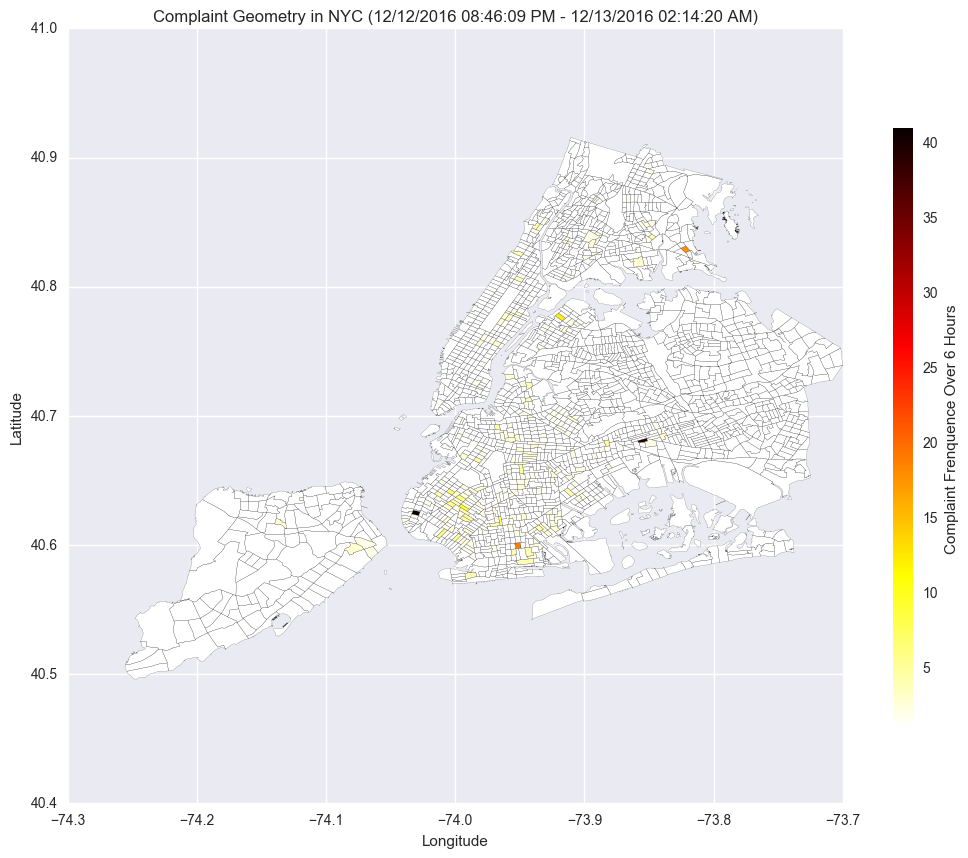

In [29]:
# Geospacical analysis on complaint 

fig, ax = plt.subplots(figsize=(10,10))

ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
regions.plot(column='Complaint Number',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Complaint Geometry in NYC (12/12/2016 08:46:09 PM - 12/13/2016 02:14:20 AM)")
norm = mpl.colors.Normalize(vmin=regions['Complaint Number'].min(),
                              vmax=regions['Complaint Number'].max())
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='hot_r', norm=norm, spacing='proportional')
cb.set_label('Complaint Frenquence Over 6 Hours')

### Download the New York City Leading Causes of Death Data  (2007-2011)

In [30]:
dx= pd.read_csv(os.getenv("PUIDATA") + '/New_York_City_Leading_Causes_of_Death.csv')
dx.head()

,Year,Ethnicity,Sex,Cause of Death,Count,Percent
0,2010,NON-HISPANIC BLACK,MALE,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,297,5
1,2010,NON-HISPANIC BLACK,MALE,INFLUENZA AND PNEUMONIA,201,3
2,2010,NON-HISPANIC BLACK,MALE,INTENTIONAL SELF-HARM (SUICIDE),64,1
3,2010,NON-HISPANIC BLACK,MALE,MALIGNANT NEOPLASMS,1540,23
4,2010,NON-HISPANIC BLACK,MALE,MENTAL DISORDERS DUE TO USE OF ALCOHOL,50,1


In [31]:
dx.isnull().sum()

Year              0
Ethnicity         0
Sex               0
Cause of Death    0
Count             0
Percent           0
dtype: int64

In [32]:
len(dx['Cause of Death'].unique())

32

In [33]:
dx_07=dx[dx['Year'] == 2007]
dx_07_com = dx_07.groupby('Cause of Death')['Count'].sum()
dx_07_com = dx_07_com.sort_values(ascending=0).reset_index()
dx_07_com#.head(2)

,Cause of Death,Count
0,DISEASES OF HEART,84780
1,MALIGNANT NEOPLASMS,52416
2,INFLUENZA AND PNEUMONIA,8876
3,CEREBROVASCULAR DISEASE,6188
4,DIABETES MELLITUS,6140
5,CHRONIC LOWER RESPIRATORY DISEASES,5644
6,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,4380
7,ACCIDENTS EXCEPT DRUG POISONING,4064
8,PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING,3336
9,ESSENTIAL HYPERTENSION AND RENAL DISEASES,3128


In [34]:
len(dx_07['Cause of Death'].unique())

30

/Users/YueCai/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


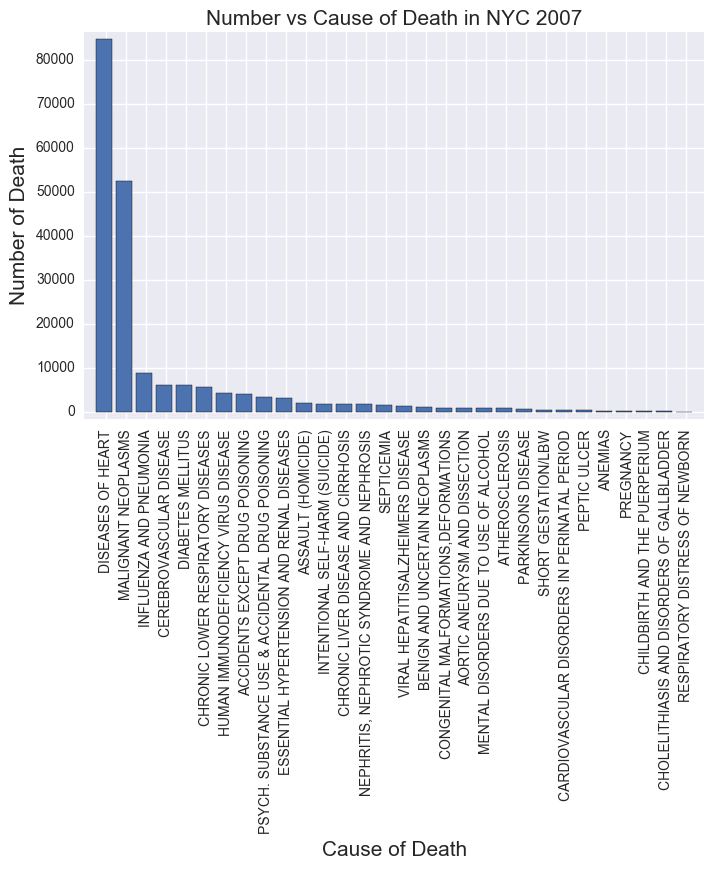

In [35]:
ax = plt.figure(figsize=(8,5))

Y = dx_07_com['Count']
X = range(30)
labels = ['DISEASES OF HEART' ,'MALIGNANT NEOPLASMS','INFLUENZA AND PNEUMONIA',
          'CEREBROVASCULAR DISEASE','DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','ACCIDENTS EXCEPT DRUG POISONING',
          'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES','ASSAULT (HOMICIDE)',
          'INTENTIONAL SELF-HARM (SUICIDE)','CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS','SEPTICEMIA','VIRAL HEPATITIS'
          'ALZHEIMERS DISEASE','BENIGN AND UNCERTAIN NEOPLASMS',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','AORTIC ANEURYSM AND DISSECTION',
          'MENTAL DISORDERS DUE TO USE OF ALCOHOL','ATHEROSCLEROSIS','PARKINSONS DISEASE',
          'SHORT GESTATION/LBW','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'PEPTIC ULCER','ANEMIAS','PREGNANCY', 'CHILDBIRTH AND THE PUERPERIUM',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','RESPIRATORY DISTRESS OF NEWBORN']


plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2007',fontsize=15)
plt.margins(0.02)

plt.legend(loc='best')

In [36]:
MP07 = dx_07_com.copy()
MP07['Cause of Death'].replace({'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING': 'MENTAL HEALTH', 
                      'ASSAULT (HOMICIDE)': 'MENTAL HEALTH','INTENTIONAL SELF-HARM (SUICIDE)':'MENTAL HEALTH', 
                      'MENTAL DISORDERS DUE TO USE OF ALCOHOL':'MENTAL HEALTH', 
                      'PARKINSONS DISEASE':'MENTAL HEALTH'}, inplace = True)

In [37]:
MP07_ = MP07.groupby('Cause of Death')['Count'].sum()

In [38]:
MP_07_ = MP07_.sort_values(ascending=0).reset_index()
MP_07_.drop(MP_07_.index[:3], inplace=True)
MP_07_.head()

,Cause of Death,Count
3,MENTAL HEALTH,8472
4,CEREBROVASCULAR DISEASE,6188
5,DIABETES MELLITUS,6140
6,CHRONIC LOWER RESPIRATORY DISEASES,5644
7,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,4380


In [39]:
x = MP_07_ ['Count'].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
MP_07_ ['Count'] = pd.DataFrame(x_scaled)
MP_07_.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Cause of Death,Count
3,MENTAL HEALTH,0.665088
4,CEREBROVASCULAR DISEASE,0.515396
5,DIABETES MELLITUS,0.477973
6,CHRONIC LOWER RESPIRATORY DISEASES,0.367125
7,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,0.207485


In [40]:
len(MP_07_)

23

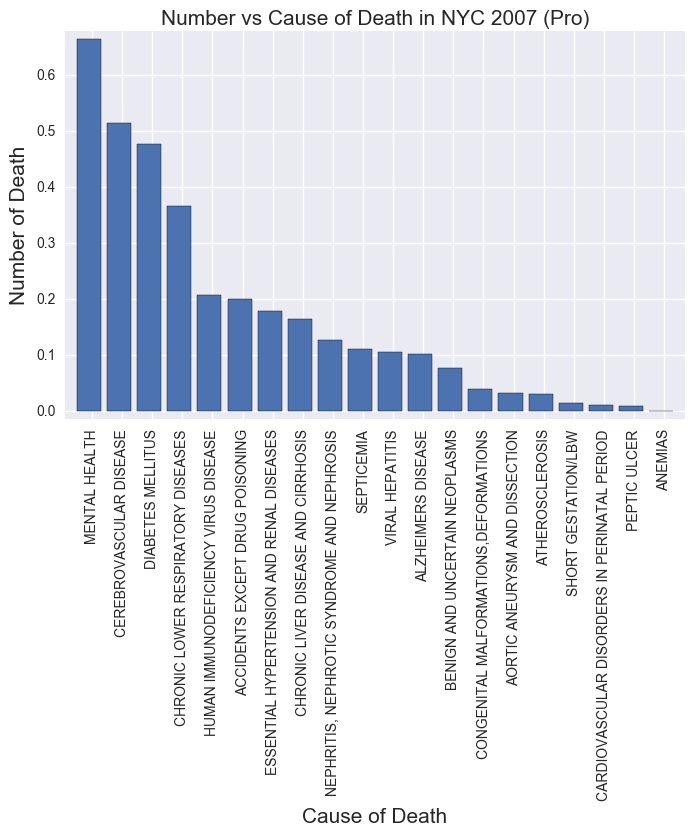

In [41]:
ax = plt.figure(figsize=(8,5))

Y = MP_07_['Count']

X = range(23)
labels = ['MENTAL HEALTH','CEREBROVASCULAR DISEASE','DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','ACCIDENTS EXCEPT DRUG POISONING',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS','SEPTICEMIA','VIRAL HEPATITIS',
          'ALZHEIMERS DISEASE','BENIGN AND UNCERTAIN NEOPLASMS',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','AORTIC ANEURYSM AND DISSECTION',
          'ATHEROSCLEROSIS',
          'SHORT GESTATION/LBW','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'PEPTIC ULCER','ANEMIAS','PREGNANCY, CHILDBIRTH AND THE PUERPERIUM',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','RESPIRATORY DISTRESS OF NEWBORN']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2007 (Pro)',fontsize=15)
plt.margins(0.02)

In [42]:
dx_08=dx[dx['Year'] == 2008]
dx_08_com = dx_08.groupby('Cause of Death')['Count'].sum()
dx_08_com = dx_08_com.sort_values(ascending=0).reset_index()
dx_08_com.head(2)

,Cause of Death,Count
0,DISEASES OF HEART,83672
1,MALIGNANT NEOPLASMS,51588


In [43]:
MP08 = dx_08_com.copy()
MP08['Cause of Death'].replace({'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING': 'MENTAL HEALTH', 
                      'ASSAULT (HOMICIDE)': 'MENTAL HEALTH','INTENTIONAL SELF-HARM (SUICIDE)':'MENTAL HEALTH', 
                      'MENTAL DISORDERS DUE TO USE OF ALCOHOL':'MENTAL HEALTH',                       'PARKINSONS DISEASE':'MENTAL HEALTH'}, inplace = True)

MP08_ = MP08.groupby('Cause of Death')['Count'].sum()
MP_08_ = MP08_.sort_values(ascending=0).reset_index()
MP_08_.drop(MP_08_.index[:3], inplace=True)
MP_08_.head()

,Cause of Death,Count
3,MENTAL HEALTH,8144
4,DIABETES MELLITUS,6480
5,CHRONIC LOWER RESPIRATORY DISEASES,6356
6,CEREBROVASCULAR DISEASE,5944
7,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,4216


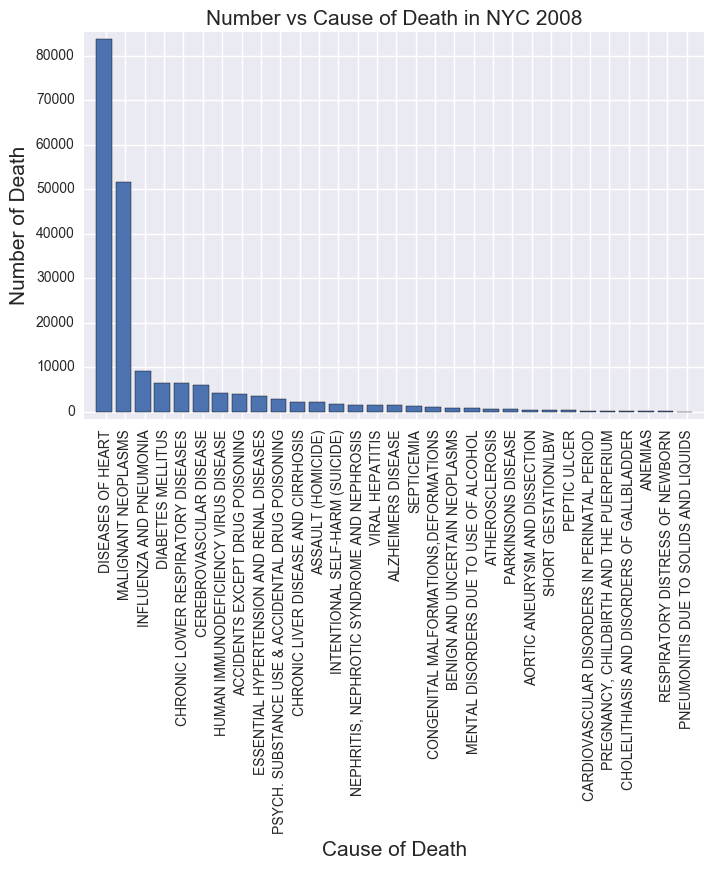

In [44]:
ax = plt.figure(figsize=(8,5))

Y = dx_08_com['Count']

X = range(31)
labels = ['DISEASES OF HEART','MALIGNANT NEOPLASMS','INFLUENZA AND PNEUMONIA',
          'DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES',
          'CEREBROVASCULAR DISEASE','HUMAN IMMUNODEFICIENCY VIRUS DISEASE',
          'ACCIDENTS EXCEPT DRUG POISONING','ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING',
          'CHRONIC LIVER DISEASE AND CIRRHOSIS','ASSAULT (HOMICIDE)',
          'INTENTIONAL SELF-HARM (SUICIDE)','NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'VIRAL HEPATITIS','ALZHEIMERS DISEASE','SEPTICEMIA',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','BENIGN AND UNCERTAIN NEOPLASMS',
          'MENTAL DISORDERS DUE TO USE OF ALCOHOL','ATHEROSCLEROSIS',
          'PARKINSONS DISEASE','AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW',
          'PEPTIC ULCER','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','CHOLELITHIASIS AND DISORDERS OF GALLBLADDER',
          'ANEMIAS','RESPIRATORY DISTRESS OF NEWBORN','PNEUMONITIS DUE TO SOLIDS AND LIQUIDS']


plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2008',fontsize=15)
plt.margins(0.02)

plt.legend(loc='best')

In [45]:
x = MP_08_ ['Count'].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
MP_08_ ['Count'] = pd.DataFrame(x_scaled)
MP_08_.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Cause of Death,Count
3,MENTAL HEALTH,0.728797
4,DIABETES MELLITUS,0.515779
5,CHRONIC LOWER RESPIRATORY DISEASES,0.501972
6,CEREBROVASCULAR DISEASE,0.429487
7,HUMAN IMMUNODEFICIENCY VIRUS DISEASE,0.258383


In [46]:
len(MP_08_)

24

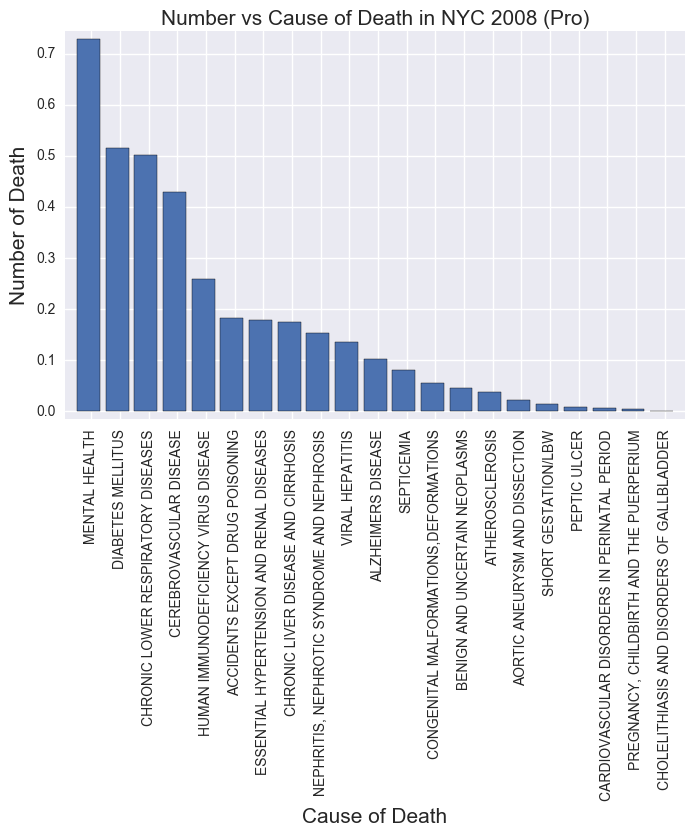

In [47]:
ax = plt.figure(figsize=(8,5))

Y = MP_08_['Count']

X = range(24)
labels = ['MENTAL HEALTH','DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES',
          'CEREBROVASCULAR DISEASE','HUMAN IMMUNODEFICIENCY VIRUS DISEASE',
          'ACCIDENTS EXCEPT DRUG POISONING','ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'CHRONIC LIVER DISEASE AND CIRRHOSIS','NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'VIRAL HEPATITIS','ALZHEIMERS DISEASE','SEPTICEMIA',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','BENIGN AND UNCERTAIN NEOPLASMS',
          'ATHEROSCLEROSIS','AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW',
          'PEPTIC ULCER','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','CHOLELITHIASIS AND DISORDERS OF GALLBLADDER',
          'ANEMIAS','RESPIRATORY DISTRESS OF NEWBORN','PNEUMONITIS DUE TO SOLIDS AND LIQUIDS']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2008 (Pro)',fontsize=15)
plt.margins(0.02)

In [48]:
dx_09=dx[dx['Year'] == 2009]
dx_09_com = dx_09.groupby('Cause of Death')['Count'].sum()
dx_09_com = dx_09_com.sort_values(ascending=0).reset_index()
dx_09_com.head(2)

,Cause of Death,Count
0,DISEASES OF HEART,79212
1,MALIGNANT NEOPLASMS,52244


In [49]:
len(dx_09['Cause of Death'].unique())

29

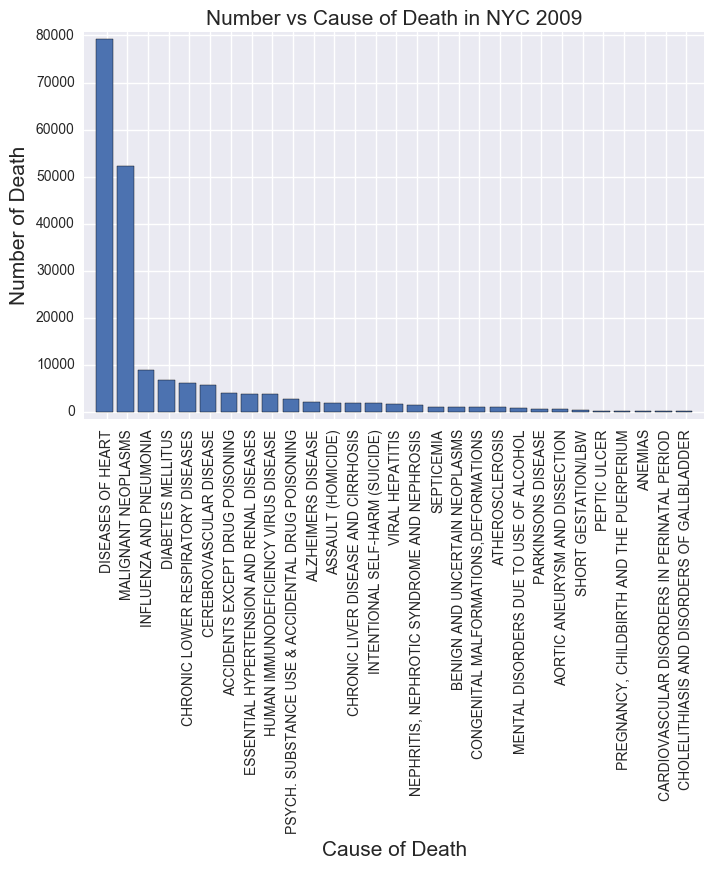

In [50]:
ax = plt.figure(figsize=(8,5))

Y = dx_09_com['Count']

X = range(29)
labels = ['DISEASES OF HEART','MALIGNANT NEOPLASMS','INFLUENZA AND PNEUMONIA',
          'DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES','CEREBROVASCULAR DISEASE',
          'ACCIDENTS EXCEPT DRUG POISONING','ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING',
          'ALZHEIMERS DISEASE','ASSAULT (HOMICIDE)','CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'INTENTIONAL SELF-HARM (SUICIDE)','VIRAL HEPATITIS','NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'SEPTICEMIA','BENIGN AND UNCERTAIN NEOPLASMS','CONGENITAL MALFORMATIONS,DEFORMATIONS',
          'ATHEROSCLEROSIS','MENTAL DISORDERS DUE TO USE OF ALCOHOL','PARKINSONS DISEASE',
          'AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW','PEPTIC ULCER',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','ANEMIAS','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2009',fontsize=15)
plt.margins(0.02)

plt.legend(loc='best')

In [51]:
MP09 = dx_09_com.copy()
MP09['Cause of Death'].replace({'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING': 'MENTAL HEALTH', 
                      'ASSAULT (HOMICIDE)': 'MENTAL HEALTH','INTENTIONAL SELF-HARM (SUICIDE)':'MENTAL HEALTH', 
                      'MENTAL DISORDERS DUE TO USE OF ALCOHOL':'MENTAL HEALTH',                       'PARKINSONS DISEASE':'MENTAL HEALTH'}, inplace = True)

MP09_ = MP09.groupby('Cause of Death')['Count'].sum()
MP_09_ = MP09_.sort_values(ascending=0).reset_index()
MP_09_.drop(MP_09_.index[:3], inplace=True)
MP_09_.head()

,Cause of Death,Count
3,MENTAL HEALTH,8000
4,DIABETES MELLITUS,6712
5,CHRONIC LOWER RESPIRATORY DISEASES,6044
6,CEREBROVASCULAR DISEASE,5728
7,ACCIDENTS EXCEPT DRUG POISONING,3932


In [52]:
x = MP_09_ ['Count'].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
MP_09_ ['Count'] = pd.DataFrame(x_scaled)
MP_09_.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Cause of Death,Count
3,MENTAL HEALTH,0.713565
4,DIABETES MELLITUS,0.487141
5,CHRONIC LOWER RESPIRATORY DISEASES,0.458396
6,CEREBROVASCULAR DISEASE,0.454866
7,ACCIDENTS EXCEPT DRUG POISONING,0.250630


In [53]:
len(MP_09_)

22

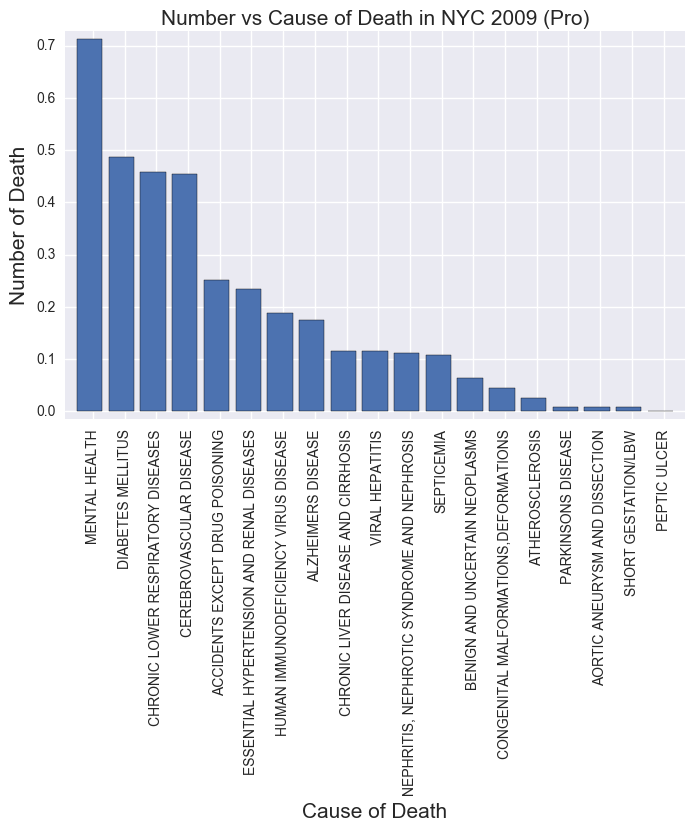

In [54]:
ax = plt.figure(figsize=(8,5))

Y = MP_09_['Count']

X = range(22)
labels = ['MENTAL HEALTH','DIABETES MELLITUS','CHRONIC LOWER RESPIRATORY DISEASES','CEREBROVASCULAR DISEASE',
          'ACCIDENTS EXCEPT DRUG POISONING','ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE',
          'ALZHEIMERS DISEASE','CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'VIRAL HEPATITIS','NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'SEPTICEMIA','BENIGN AND UNCERTAIN NEOPLASMS','CONGENITAL MALFORMATIONS,DEFORMATIONS',
          'ATHEROSCLEROSIS','PARKINSONS DISEASE',
          'AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW','PEPTIC ULCER',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','ANEMIAS','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2009 (Pro)',fontsize=15)
plt.margins(0.02)

In [55]:
dx_10=dx[dx['Year'] == 2010]
dx_10_com = dx_10.groupby('Cause of Death')['Count'].sum()
dx_10_com = dx_10_com.sort_values(ascending=0).reset_index()
dx_10_com.head(2)

,Cause of Death,Count
0,DISEASES OF HEART,70748
1,MALIGNANT NEOPLASMS,52796


In [56]:
len(dx_10['Cause of Death'].unique())

30

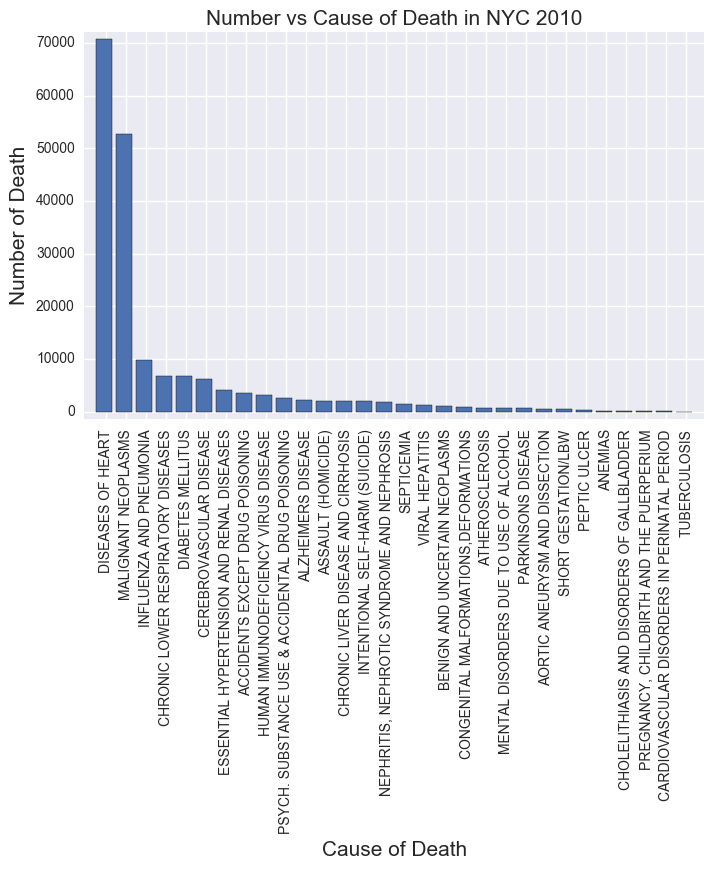

In [57]:
ax = plt.figure(figsize=(8,5))

Y = dx_10_com['Count']

X = range(30)
labels = ['DISEASES OF HEART','MALIGNANT NEOPLASMS','INFLUENZA AND PNEUMONIA',
          'CHRONIC LOWER RESPIRATORY DISEASES','DIABETES MELLITUS','CEREBROVASCULAR DISEASE',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES','ACCIDENTS EXCEPT DRUG POISONING',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING',
          'ALZHEIMERS DISEASE','ASSAULT (HOMICIDE)','CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'INTENTIONAL SELF-HARM (SUICIDE)','NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'SEPTICEMIA','VIRAL HEPATITIS','BENIGN AND UNCERTAIN NEOPLASMS',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','ATHEROSCLEROSIS',
          'MENTAL DISORDERS DUE TO USE OF ALCOHOL','PARKINSONS DISEASE',
          'AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW','PEPTIC ULCER','ANEMIAS',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','PREGNANCY, CHILDBIRTH AND THE PUERPERIUM',
          'CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD','TUBERCULOSIS']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2010',fontsize=15)
plt.margins(0.02)

plt.legend(loc='best')

In [58]:
MP10 = dx_10_com.copy()
MP10['Cause of Death'].replace({'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING': 'MENTAL HEALTH', 
                      'ASSAULT (HOMICIDE)': 'MENTAL HEALTH','INTENTIONAL SELF-HARM (SUICIDE)':'MENTAL HEALTH', 
                      'MENTAL DISORDERS DUE TO USE OF ALCOHOL':'MENTAL HEALTH',                       'PARKINSONS DISEASE':'MENTAL HEALTH'}, inplace = True)

MP10_ = MP10.groupby('Cause of Death')['Count'].sum()
MP_10_ = MP10_.sort_values(ascending=0).reset_index()
MP_10_.drop(MP_10_.index[:3], inplace=True)
MP_10_.head()

,Cause of Death,Count
3,MENTAL HEALTH,8092
4,CHRONIC LOWER RESPIRATORY DISEASES,6768
5,DIABETES MELLITUS,6748
6,CEREBROVASCULAR DISEASE,6272
7,ESSENTIAL HYPERTENSION AND RENAL DISEASES,4140


In [59]:
x = MP_10_ ['Count'].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
MP_10_ ['Count'] = pd.DataFrame(x_scaled)
MP_10_.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Cause of Death,Count
3,MENTAL HEALTH,0.774529
4,CHRONIC LOWER RESPIRATORY DISEASES,0.510406
5,DIABETES MELLITUS,0.449950
6,CEREBROVASCULAR DISEASE,0.402379
7,ESSENTIAL HYPERTENSION AND RENAL DISEASES,0.281962


In [60]:
len(MP_10_)

23

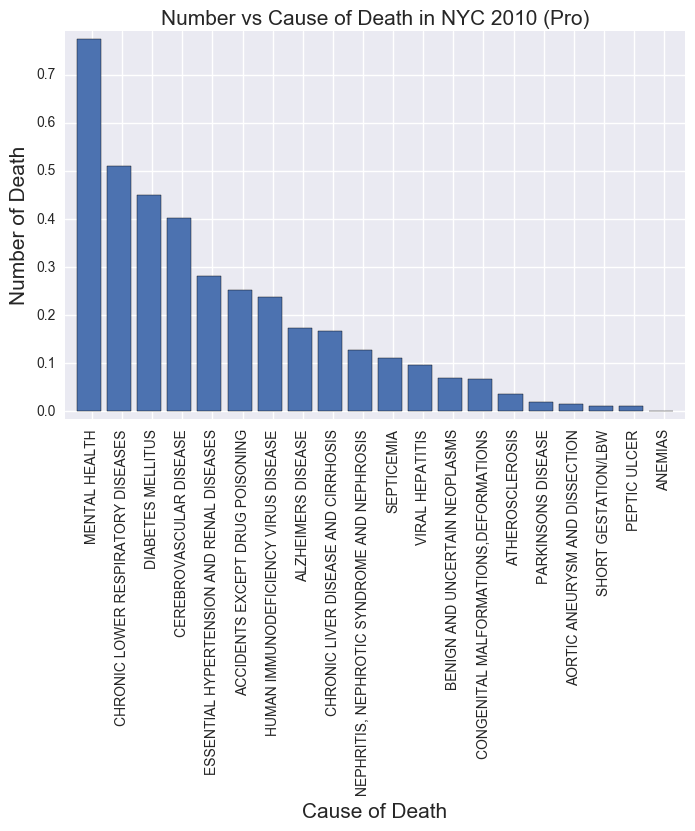

In [61]:
ax = plt.figure(figsize=(8,5))

Y = MP_10_['Count']

X = range(23)
labels = ['MENTAL HEALTH','CHRONIC LOWER RESPIRATORY DISEASES','DIABETES MELLITUS','CEREBROVASCULAR DISEASE',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES','ACCIDENTS EXCEPT DRUG POISONING',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE',
          'ALZHEIMERS DISEASE','CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS',
          'SEPTICEMIA','VIRAL HEPATITIS','BENIGN AND UNCERTAIN NEOPLASMS',
          'CONGENITAL MALFORMATIONS,DEFORMATIONS','ATHEROSCLEROSIS','PARKINSONS DISEASE',
          'AORTIC ANEURYSM AND DISSECTION','SHORT GESTATION/LBW','PEPTIC ULCER','ANEMIAS',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','PREGNANCY, CHILDBIRTH AND THE PUERPERIUM',
          'CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD','TUBERCULOSIS']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2010 (Pro)',fontsize=15)
plt.margins(0.02)

In [62]:
dx_11=dx[dx['Year'] == 2011]
dx_11_com = dx_11.groupby('Cause of Death')['Count'].sum()
dx_11_com = dx_11_com.sort_values(ascending=0).reset_index()
dx_11_com.head(2)

,Cause of Death,Count
0,DISEASES OF HEART,66888
1,MALIGNANT NEOPLASMS,53344


In [63]:
len(dx_11['Cause of Death'].unique())

30

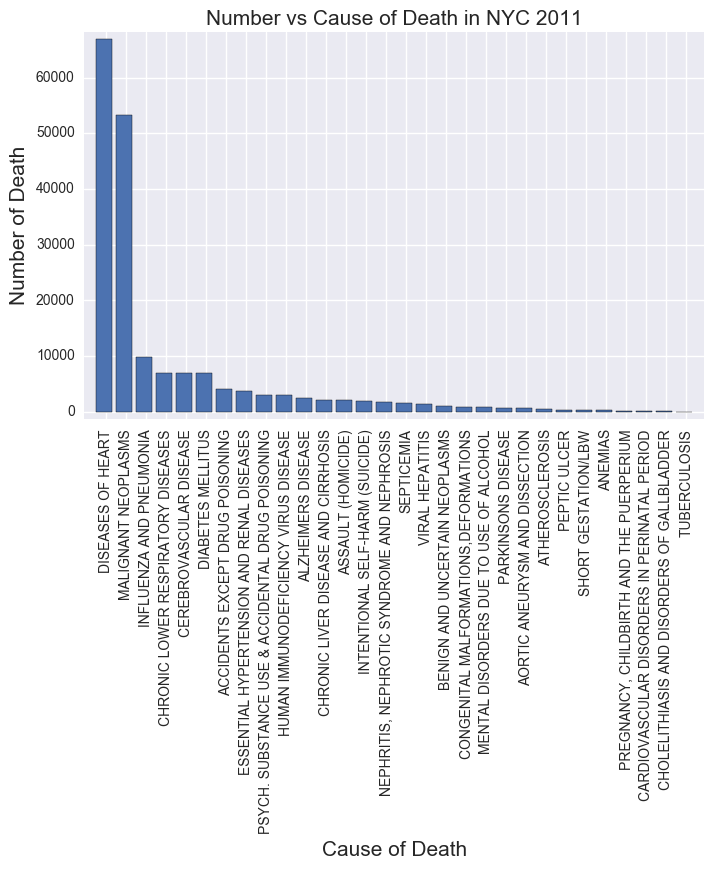

In [64]:
ax = plt.figure(figsize=(8,5))

Y = dx_11_com['Count']

X = range(30)
labels = ['DISEASES OF HEART','MALIGNANT NEOPLASMS','INFLUENZA AND PNEUMONIA',
          'CHRONIC LOWER RESPIRATORY DISEASES','CEREBROVASCULAR DISEASE',
          'DIABETES MELLITUS','ACCIDENTS EXCEPT DRUG POISONING',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES','PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','ALZHEIMERS DISEASE',
          'CHRONIC LIVER DISEASE AND CIRRHOSIS','ASSAULT (HOMICIDE)','INTENTIONAL SELF-HARM (SUICIDE)',
          'NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS','SEPTICEMIA','VIRAL HEPATITIS',
          'BENIGN AND UNCERTAIN NEOPLASMS','CONGENITAL MALFORMATIONS,DEFORMATIONS',
          'MENTAL DISORDERS DUE TO USE OF ALCOHOL','PARKINSONS DISEASE','AORTIC ANEURYSM AND DISSECTION',
          'ATHEROSCLEROSIS','PEPTIC ULCER','SHORT GESTATION/LBW','ANEMIAS',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','TUBERCULOSIS']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2011',fontsize=15)
plt.margins(0.02)

plt.legend(loc='best')

In [65]:
MP11 = dx_11_com.copy()
MP11['Cause of Death'].replace({'PSYCH. SUBSTANCE USE & ACCIDENTAL DRUG POISONING': 'MENTAL HEALTH', 
                      'ASSAULT (HOMICIDE)': 'MENTAL HEALTH','INTENTIONAL SELF-HARM (SUICIDE)':'MENTAL HEALTH', 
                      'MENTAL DISORDERS DUE TO USE OF ALCOHOL':'MENTAL HEALTH',                       'PARKINSONS DISEASE':'MENTAL HEALTH'}, inplace = True)

MP11_ = MP11.groupby('Cause of Death')['Count'].sum()
MP_11_ = MP11_.sort_values(ascending=0).reset_index()
MP_11_.drop(MP_11_.index[:3], inplace=True)
MP_11_.head()

,Cause of Death,Count
3,MENTAL HEALTH,8556
4,CHRONIC LOWER RESPIRATORY DISEASES,7032
5,CEREBROVASCULAR DISEASE,6960
6,DIABETES MELLITUS,6940
7,ACCIDENTS EXCEPT DRUG POISONING,4008


In [66]:
x = MP_11_ ['Count'].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
MP_11_ ['Count'] = pd.DataFrame(x_scaled)
MP_11_.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/YueCai/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,Cause of Death,Count
3,MENTAL HEALTH,0.810240
4,CHRONIC LOWER RESPIRATORY DISEASES,0.465946
5,CEREBROVASCULAR DISEASE,0.443870
6,DIABETES MELLITUS,0.346172
7,ACCIDENTS EXCEPT DRUG POISONING,0.286050


In [67]:
len(MP_11_)

23

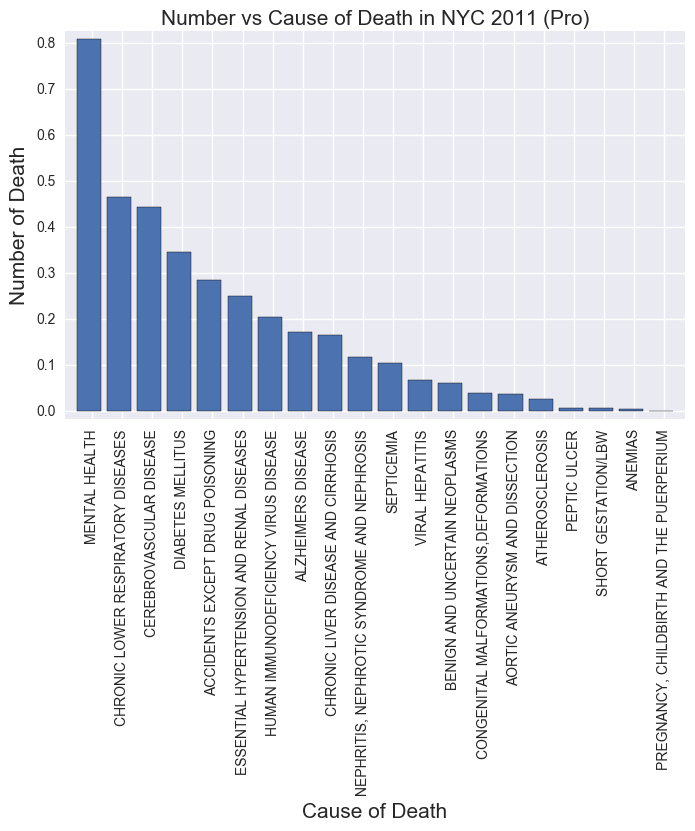

In [68]:
ax = plt.figure(figsize=(8,5))

Y = MP_11_['Count']

X = range(23)
labels = ['MENTAL HEALTH','CHRONIC LOWER RESPIRATORY DISEASES','CEREBROVASCULAR DISEASE',
          'DIABETES MELLITUS','ACCIDENTS EXCEPT DRUG POISONING',
          'ESSENTIAL HYPERTENSION AND RENAL DISEASES',
          'HUMAN IMMUNODEFICIENCY VIRUS DISEASE','ALZHEIMERS DISEASE',
          'CHRONIC LIVER DISEASE AND CIRRHOSIS',
          'NEPHRITIS, NEPHROTIC SYNDROME AND NEPHROSIS','SEPTICEMIA','VIRAL HEPATITIS',
          'BENIGN AND UNCERTAIN NEOPLASMS','CONGENITAL MALFORMATIONS,DEFORMATIONS',
          'AORTIC ANEURYSM AND DISSECTION',
          'ATHEROSCLEROSIS','PEPTIC ULCER','SHORT GESTATION/LBW','ANEMIAS',
          'PREGNANCY, CHILDBIRTH AND THE PUERPERIUM','CARDIOVASCULAR DISORDERS IN PERINATAL PERIOD',
          'CHOLELITHIASIS AND DISORDERS OF GALLBLADDER','TUBERCULOSIS']

plt.bar(X,Y)

ind = np.arange(len(labels))
plt.xticks(ind + 0.5, labels, rotation=90, fontsize=10)
plt.ylabel('Number of Death',fontsize=15)
plt.xlabel('Cause of Death',fontsize=15)
plt.title('Number vs Cause of Death in NYC 2011 (Pro)',fontsize=15)
plt.margins(0.02)